<a href="https://colab.research.google.com/github/taukappawho/nets_mod/blob/main/COSC_750_Lecture_8_Flower_Recognition(dense161)_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application on Flower Recognition [Train from Scratch]

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='https://www.dropbox.com/s/0h7exg92keuh6sg/Flowers.png?dl=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

## Step 0: Download datasets and helper functions

In [1]:
!wget https://www.dropbox.com/s/df2k5yno1iqw2vb/helper.py
!wget https://www.dropbox.com/s/6i02k74ciplutal/cat_to_name.json

--2025-03-07 12:26:38--  https://www.dropbox.com/s/df2k5yno1iqw2vb/helper.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/ju4jacflbcainywn858il/helper.py?rlkey=kxtvr4mbud5dd6apro3cu8dd2 [following]
--2025-03-07 12:26:39--  https://www.dropbox.com/scl/fi/ju4jacflbcainywn858il/helper.py?rlkey=kxtvr4mbud5dd6apro3cu8dd2
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6e778293b218269ba48d03b3f6.dl.dropboxusercontent.com/cd/0/inline/ClYKSGxGwul3PydgTDZflF8ASiTjPi1vCQiW4SiZf1unk2kcyjeJ5Fl2W_dWiJz-SCq9OzOtc_p94gjZQfxC6FiSaAWvvG_gGRpx80t7WsOkXOXKzyrvvynZ-XQtF25G-bwUt_8omeCHCz4jvNFRg95b/file# [following]
--2025-03-07 12:26:40--  https://uc6e778293b218269ba48d03b3f6.dl.dropboxusercontent.com/cd/0/inline/ClYKSGxG

In [2]:
!wget https://www.dropbox.com/s/yhpfbn3k19rvchm/flower_data.zip
!unzip -q flower_data.zip

--2025-03-07 12:26:43--  https://www.dropbox.com/s/yhpfbn3k19rvchm/flower_data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/j357fy7sfynrqjzgf2cjj/flower_data.zip?rlkey=ly4ktkgfftji845r1ndwoiorg [following]
--2025-03-07 12:26:44--  https://www.dropbox.com/scl/fi/j357fy7sfynrqjzgf2cjj/flower_data.zip?rlkey=ly4ktkgfftji845r1ndwoiorg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d0d38f5b39c5323a8303e7a94.dl.dropboxusercontent.com/cd/0/inline/Cla0P-j21EcopWgcnYFnvEGGR942FEm7tk_PKJXU-TUutYi1Kjc_F4iSZiAxRmRmxPK5XqdtT_FhHwJiiG7gya1VhElOWetvHNp94LR4sI_Ijxm7SL3fhP1u6STR9HcY8OY2xA0PGAoVc3IAfEA0993x/file# [following]
--2025-03-07 12:26:44--  https://uc0d0d38f5b39c5323a8303e7a94.dl.dropboxusercontent.com/cd

Some Summary:

- Dataset size: 595.8 MB
- Model: DenseNet-161 (100MB in size)
- Batch_size = 32 -> Valid accuracy: 0.9404
- GPU_memory: 3435MB
-----
- Batch_size = 128 -> Valid accuracy: 0.9608
- GPU_memory: 6739MB
-----
- Batch_size = 512 -> Valid accuracy: 0.9426
- GPU_memory: 21023MB

## Step 1: Load the data and data augmentation

### Step 1.1: Load the data with augmentation via `transforms`

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from collections import OrderedDict
import time
from PIL import Image
import helper

#### **!!! Always remember fix your random seed for REPRODUCIBILITY !!!**

In [4]:
torch.manual_seed(0)

In [5]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'

In [6]:
# TODO: Define your transforms for the training and validation sets
# Training data augmentation
train_transforms = transforms.Compose([transforms.RandomRotation(30), # Random rotation with 30 degree
                                       transforms.RandomResizedCrop(224), # Random crop with size of 224*224
                                       transforms.RandomHorizontalFlip(), # Random horizontal flip
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], # Data normalization
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256), # Resize the image in 255 * 255 before cropping
                                      transforms.CenterCrop(224), # Center crop with size of 224*224
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], # Data normalization
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms) # Load training data with transformation
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms) # Load validation data with transformation

# TODO: Using the image datasets and the trainforms, define the dataloaders
batch_size = 32 # save to checkpoints
trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True) # Training dataloader in batch size of 64
validloader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = True) # Validation dataloader in batch size of 64

### Step 1.2: Image Preprocessing Verification and Visualization

First you'll need to handle processing the input image such that it can be used in your network.


You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [7]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    PIL_image = Image.open(image)

    # TODO: Process a PIL image for use in a PyTorch model
    process = transforms.Compose([transforms.Resize(256), # Resize the image in 255 * 255 before cropping
                                  transforms.CenterCrop(224), # Center crop with size of 224*224
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], # Data normalization
                                                       [0.229, 0.224, 0.225])])
    tensor_image = process(PIL_image)

    return tensor_image

In [8]:
def imshow(image, ax=None, need_norm = False, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    if title != 'Original':
        # PyTorch tensors assume the color channel is the first dimension
        # but matplotlib assumes is the third dimension
        #print('call me:')
        #print(image.shape)
        image = image.numpy().transpose((1, 2, 0))
        #print(image.shape)

        if need_norm == True:
            # Undo preprocessing
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean

        # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
        image = np.clip(image, 0, 1)

    ax.imshow(image)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title != None:
        ax.set_xlabel(title, fontsize = 'large', fontweight = 'bold')

    return ax

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

<Axes: xlabel='Recovery'>

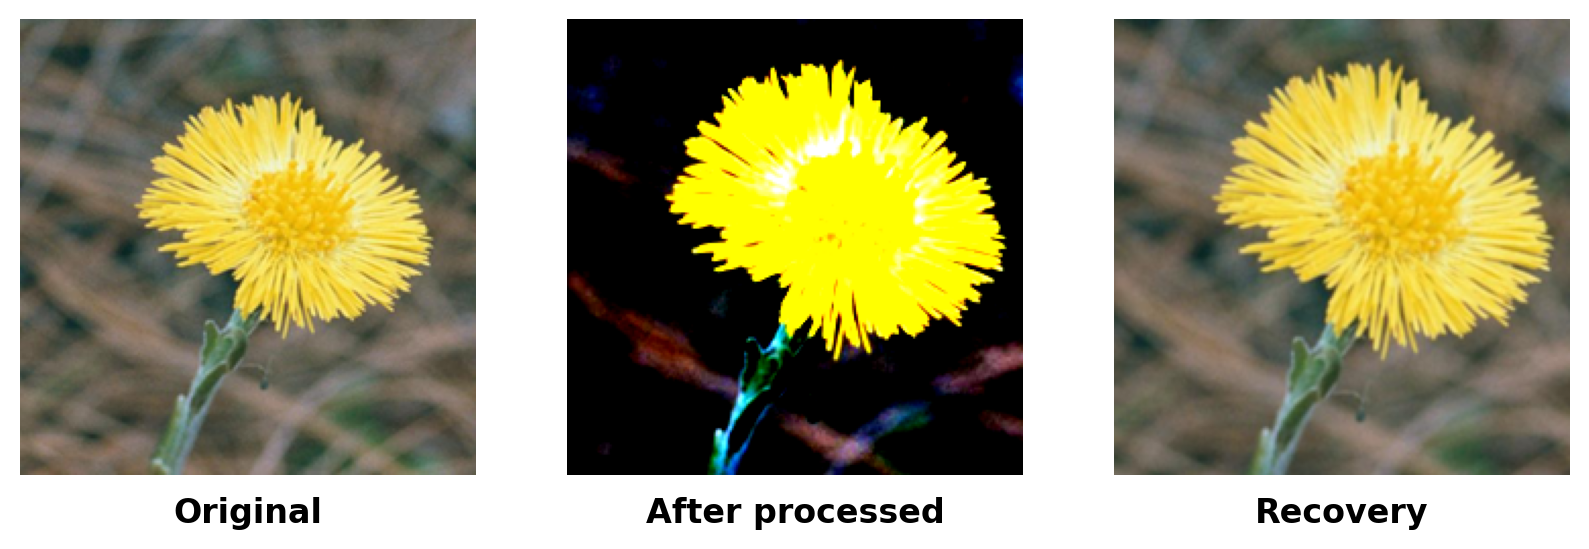

In [9]:
image_path = valid_dir + '/12' +'/image_04013.jpg'
PIL_image = Image.open(image_path)
PIL_image = PIL_image.resize((224,224), Image.ADAPTIVE)
processed_image = process_image(image_path)
fig, axes = plt.subplots(figsize=(10,10), ncols=3)
#print('Original')
imshow(PIL_image, ax=axes[0], need_norm = False, title='Original')
#print('After processed')
imshow(processed_image, ax=axes[1], need_norm = False, title='After processed')
#print('Recovery')
imshow(processed_image, ax=axes[2], need_norm = True, title='Recovery')

### Step 1.3: Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [11]:
# number of categories
n_output = len(cat_to_name) # save to checkpoints
print('Number of categories: %d' %(len(cat_to_name)))

Number of categories: 102


## Step 2: Building and training the CNN classifier from Scratch

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

## Step 2.1: Building the model from Scratch

In [12]:
# TODO: Build and train your network

"""
ResNet, Inception: input_size = model.fc.in_features

VGG: input_size = model.classifier[0].in_features

DenseNet: input_size = model.classifier.in_features

SqueezeNet: input_size = model.classifier[1].in_channels

AlexNet: alexnet.classifier[1].in_features

from https://medium.com/udacity/implementing-an-image-classifier-with-pytorch-part-3-6ff66106ba89
"""

# Load the network densenet161 but without pre-trained parameters any more
model = models.densenet161(pretrained=False)


# define the input size
n_input = model.classifier.in_features # save to checkpoints


# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
model.classifier = nn.Sequential(OrderedDict([
                          ('0', nn.Linear(n_input, 256)),
                          ('1', nn.ReLU()),
                          ('2', nn.Dropout(0.25)),
                          ('3', nn.Linear(256, n_output)),
                          ('4', nn.LogSoftmax(dim=1))
                          ]))

# Don't freeze parameters any more. Do backprop through all networks
for param in model.parameters():
    param.requires_grad = True

epochs = 20 # save to checkpoints
learning_rate = 0.001 # save to checkpoints

# Defein the criterion - The negative log likelihood loss
criterion = nn.NLLLoss() # save to checkpoint

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-4) # save to checkpoint

# Use GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Step 2.2: Training with backpropagation and keeping track the loss

In [13]:
losses = {'batches': [], 'train':[], 'validation':[]}

def backpropagation_track_valid_loss(model, epochs = 1, print_every = 10, learning_rate = 0.001):

    # iterations of steps and loss
    steps = 0
    running_loss = 0

    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1

            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear the previous gradients, do this because gradients are accumulated
            optimizer.zero_grad()

            start = time.time() # a start timer

            # back-propagation
            logps = model.forward(inputs) # transfer the input into the model and get the log of probabilities
            loss = criterion(logps, labels) # calculate the loss based on selected criterion
            loss.backward() # do one step backward to get the gradients

            optimizer.step() # update the weights

            running_loss += loss.item() # accumulated train loss
            #print(running_loss)

            if steps % print_every == 0:
                valid_loss = 0 # do the statistics on loss
                accuracy = 0 # do the statistics on accuracy
                model.eval() # set to evaluation mode

                for inputs, labels in validloader:
                    with torch.no_grad():
                        # Move input and label tensors to the default device
                        inputs, labels = inputs.to(device), labels.to(device)

                        # back-propagation
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        valid_loss += batch_loss.item() # accumulated validation loss

                        end = time.time() # an end timer

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs} .. "
                      f"Train loss: {running_loss/print_every:.4f} .. "
                      f"Vaild loss: {valid_loss/len(validloader):.4f} .. "
                      f"Valid accuracy: {accuracy/len(validloader):.4f} .. "
                      f"Time per batch: {(end - start)/print_every:.4f} seconds")


                losses['train'].append(running_loss)
                losses['validation'].append(valid_loss)
                losses['batches'].append(steps)

                running_loss = 0 # reset loss to zero
                model.train() # set to training mode

In [14]:
backpropagation_track_valid_loss(model = model, epochs = epochs, print_every = 50, learning_rate = learning_rate)

Epoch 1/20 .. Train loss: 4.4322 .. Vaild loss: 4.0732 .. Valid accuracy: 0.1046 .. Time per batch: 0.2152 seconds
Epoch 1/20 .. Train loss: 4.0401 .. Vaild loss: 3.7905 .. Valid accuracy: 0.1046 .. Time per batch: 0.2123 seconds
Epoch 1/20 .. Train loss: 3.8768 .. Vaild loss: 3.7277 .. Valid accuracy: 0.1218 .. Time per batch: 0.2042 seconds
Epoch 1/20 .. Train loss: 3.7918 .. Vaild loss: 3.5741 .. Valid accuracy: 0.1197 .. Time per batch: 0.2131 seconds
Epoch 2/20 .. Train loss: 3.6525 .. Vaild loss: 3.4592 .. Valid accuracy: 0.1691 .. Time per batch: 0.2193 seconds
Epoch 2/20 .. Train loss: 3.6709 .. Vaild loss: 3.3800 .. Valid accuracy: 0.1620 .. Time per batch: 0.2161 seconds
Epoch 2/20 .. Train loss: 3.5217 .. Vaild loss: 3.3803 .. Valid accuracy: 0.1689 .. Time per batch: 0.2153 seconds
Epoch 2/20 .. Train loss: 3.5192 .. Vaild loss: 3.2975 .. Valid accuracy: 0.1692 .. Time per batch: 0.2125 seconds
Epoch 3/20 .. Train loss: 3.3991 .. Vaild loss: 3.5058 .. Valid accuracy: 0.1975

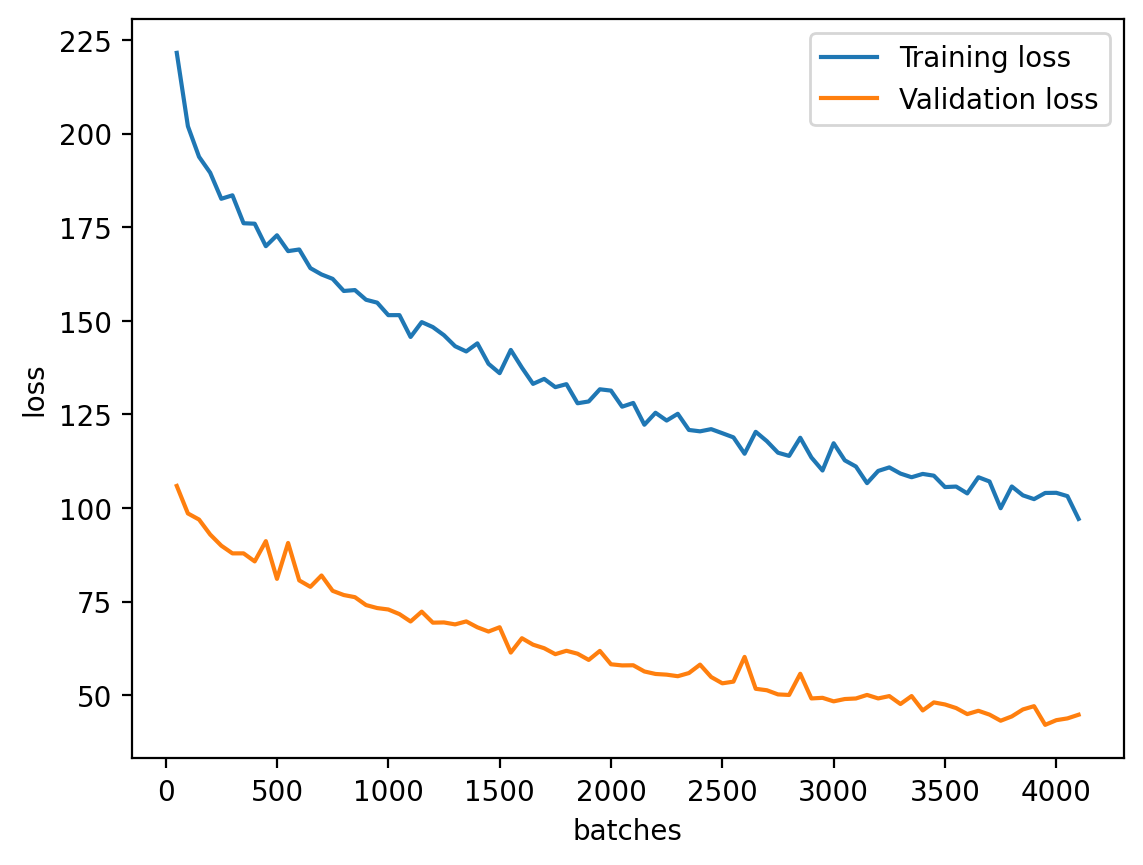

In [15]:
plt.plot(losses['batches'], losses['train'], label='Training loss')
plt.plot(losses['batches'], losses['validation'], label='Validation loss')
plt.xlabel("batches")
plt.ylabel("loss")
plt.legend()
_ = plt.ylim()

## Step 3: Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
# TODO: Save the checkpoint
model.class_to_index = trainloader.dataset.class_to_idx

def save_checkpoint(model, path = 'dense161_checkpoint_scratch.pth'):
    checkpoint = {'batch_size': batch_size,
                  'input_size': n_input,
                  'output_size': n_output,
                  'epochs': epochs,
                  'learning_rate': learning_rate,
                  'model': models.densenet161(pretrained=True),
                  'classifier': model.classifier,
                  'model_state_dict': model.state_dict(),
                  'optim_state_dict': optimizer.state_dict(),
                  'class_to_index': model.class_to_index
                 }
    torch.save(checkpoint, path)

save_checkpoint(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 162MB/s] 


## Step 4: Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [17]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def self_check():
    # Print model's state_dict
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    # Print optimizer's state_dict
    print("Optimizer's state_dict:")
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name])

def load_model(model, optimizer, path = 'dense161_checkpoint_scratch.pth'):
    checkpoint = torch.load(path)

    # first load hyper-parameters - even though not used for the following inference
    batch_size = checkpoint['batch_size']
    n_input = checkpoint['input_size']
    n_output = checkpoint['output_size']
    epochs = checkpoint['epochs']
    learning_rate = checkpoint['learning_rate']

    # second load parameters - used for the following inference
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    model.class_to_index = checkpoint['class_to_index']

    for param in model.parameters():
        param.requires_grad = False

    return model, optimizer

model, optimizer = load_model(model, optimizer)

<ipython-input-17-eebbef7f0ab9>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [18]:
# (optional) just check the loaded model's info
# self_check()

## Step 5: Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

### Step 5.1: Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
def predict(image_path, model, topk=5):
    '''
    Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to(device)
    model.eval()

    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)

    # Convert 3D image to 4D tensor to fit into batch setting
    image = image.unsqueeze(0).to(device) # (3, 224, 224) -> (1, 3, 224, 224)
    # print(image.shape)

    # feed farward to check the probs and indexs
    output = model.forward(image)
    ps = torch.exp(output)
    probs, idxs = ps.topk(topk, dim = 1)

    probs = probs.to('cpu').data.numpy().squeeze()

    # transfer indexs to a list of class_name in string
    #print(idxs.to('cpu').data.numpy().squeeze(0))
    idxs_list = idxs.to('cpu').data.numpy().squeeze()

    classes = [class_ for class_, idx in model.class_to_index.items() if idx in idxs_list]

    return probs, classes

image_path = valid_dir + '/12' +'/image_04013.jpg'
probs, classes = predict(image_path, model)
print(probs)
print(classes)

[0.8278005  0.08848118 0.03405672 0.00991318 0.00864183]
['12', '18', '47', '48', '50']


### Step 5.2: Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://www.dropbox.com/s/wl5defcecxqiwuj/inference_example.png?dl=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

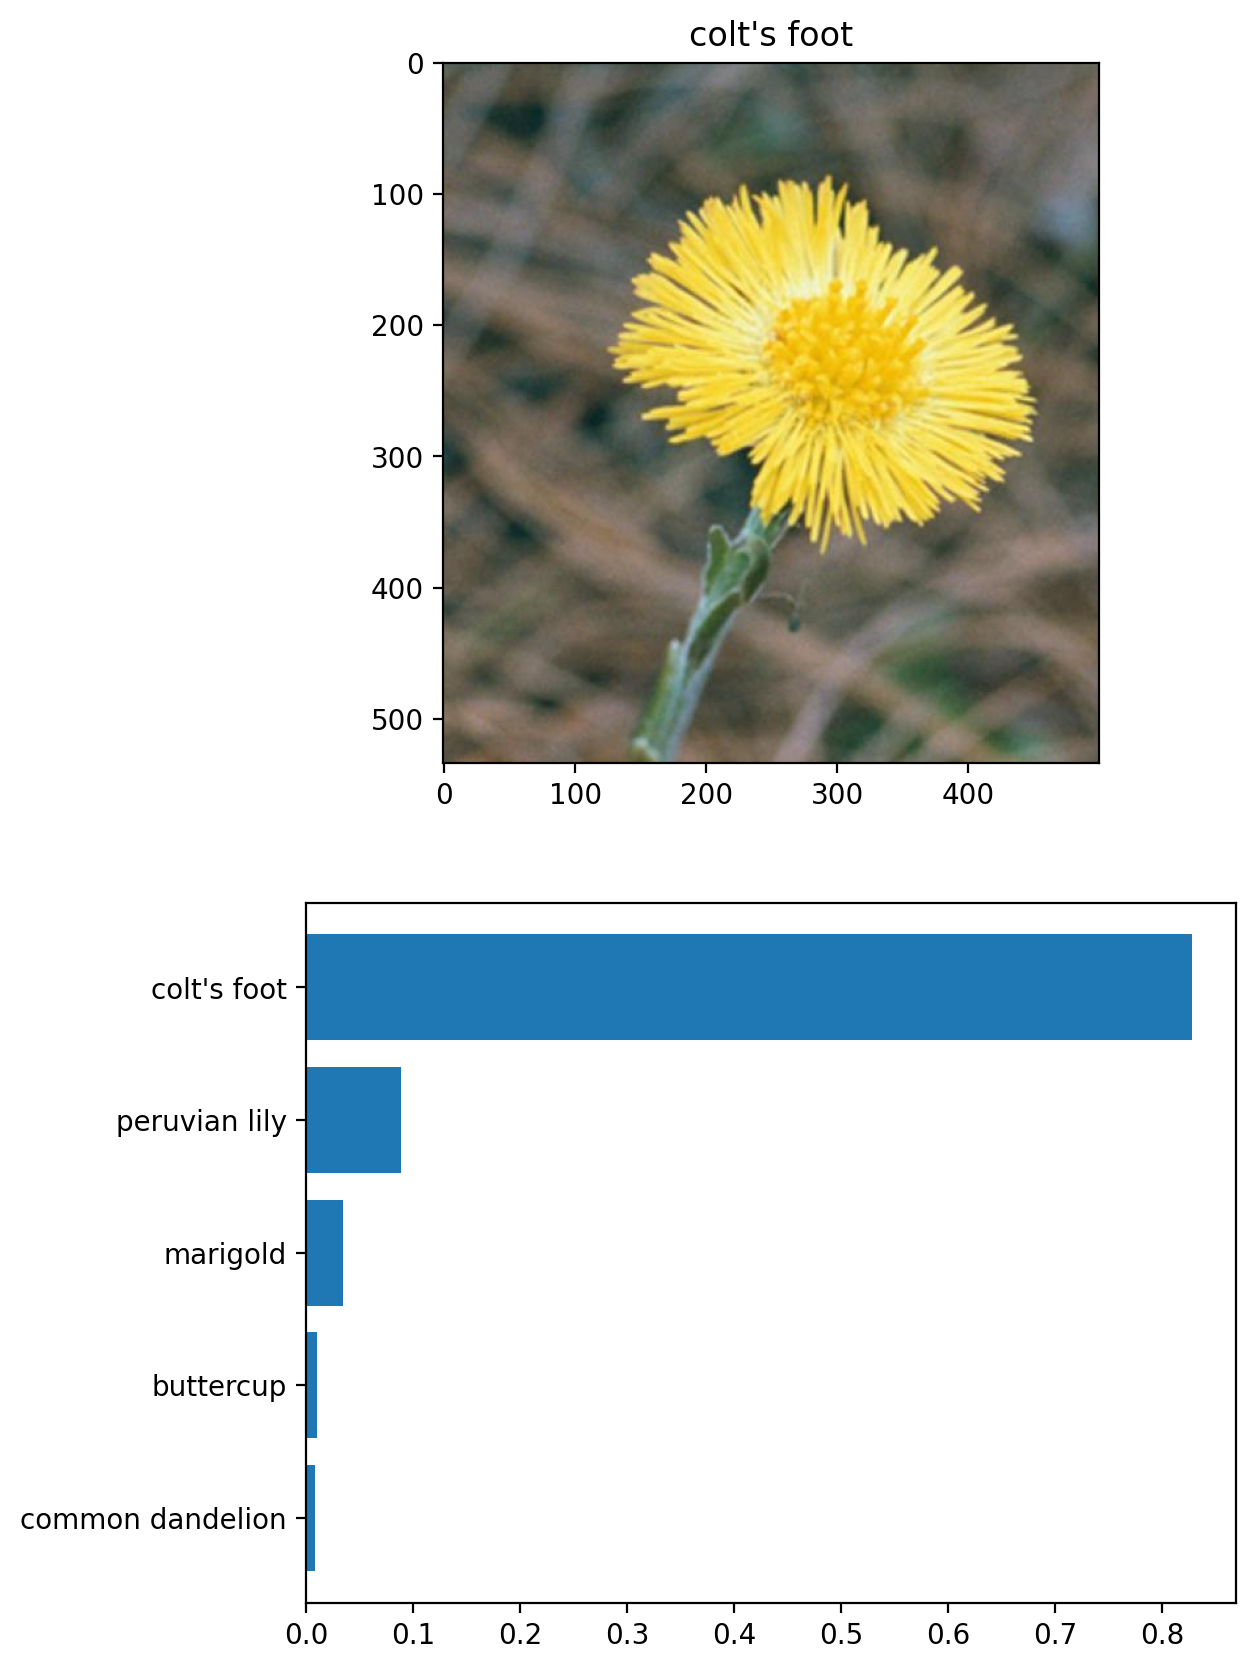

In [20]:
# TODO: Display an image along with the top 5 classes
def sanity_check(image_path, probs, classes, cat_to_name):
    image = Image.open(image_path)

    fig, (ax1, ax2) = plt.subplots(figsize = (6,10), ncols = 1, nrows = 2)
    flower_name = cat_to_name[image_path.split('/')[-2]]
    ax1.set_title(flower_name)
    ax1.imshow(image)

    topk_flower_names = [cat_to_name[classes[i]] for i in range(len(classes))]

    y_pos = np.arange(len(probs))
    ax2.barh(y_pos, probs, align = 'center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(topk_flower_names)
    ax2.invert_yaxis() # labels read top-to-bottom

sanity_check(image_path, probs, classes, cat_to_name)